# **Predicción de Precios de Vehículos Usados (Core)**

Implementar y evaluar modelos de regresión, y seleccionar el mejor modelo basado en las métricas de evaluación.

**Requisitos:**

 ## **1. Carga y Exploración de Datos:**

* **Descargar y cargar el dataset.**


In [1]:
# Importamos las librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
# Cargamos el dataset
path = '../data/vehicles.csv'
df = pd.read_csv(path)

* **Realizar una exploración inicial para entender la estructura del dataset.**

In [3]:
# Inspeccionamos el dataset
df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


* **Identificar valores faltantes, duplicados y outliers.**

In [4]:
# Identificar duplicados
duplicados = df.duplicated()
# Contar el número de duplicados
num_duplicados = duplicados.sum()
print(f"Número de registros duplicados: {num_duplicados}")

Número de registros duplicados: 0


In [5]:
# Verificamos los valores faltantes
qsna=df.shape[0]-df.isnull().sum(axis=0)
qna=df.isnull().sum(axis=0)
ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
na=pd.DataFrame(data=aux)
na.sort_values(by='Na en %',ascending=False)

# Fuente: Clase de Manejo de valores nulo

,datos sin NAs en q,Na en q,Na en %
county,0,426880,100.00
size,120519,306361,71.77
cylinders,249202,177678,41.62
condition,252776,174104,40.79
VIN,265838,161042,37.73
drive,296313,130567,30.59
paint_color,296677,130203,30.50
type,334022,92858,21.75
manufacturer,409234,17646,4.13
title_status,418638,8242,1.93


 ## **2. Limpieza y Preprocesamiento:**

* **Manejar valores faltantes.**


In [6]:
# Dividimos los datos en df numericos y categoricos para exploracion
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

num_df = df[numeric_cols]
print(num_df.columns.tolist())
print(categorical_cols.tolist())

['id', 'price', 'year', 'odometer', 'county', 'lat', 'long']
['url', 'region', 'region_url', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color', 'image_url', 'description', 'state', 'posting_date']


In [7]:
# Vemos la distribucion de valores unicos en cada columna 
def value_unique(str_col):
    return len(df[str_col].unique().tolist())/df.shape[0]

for col in categorical_cols:
    unique_ratio = value_unique(col)
    print(f"Columna '{col}': proporción de valores únicos = {unique_ratio:.2f}")

Columna 'url': proporción de valores únicos = 1.00
Columna 'region': proporción de valores únicos = 0.00
Columna 'region_url': proporción de valores únicos = 0.00
Columna 'manufacturer': proporción de valores únicos = 0.00
Columna 'model': proporción de valores únicos = 0.07
Columna 'condition': proporción de valores únicos = 0.00
Columna 'cylinders': proporción de valores únicos = 0.00
Columna 'fuel': proporción de valores únicos = 0.00
Columna 'title_status': proporción de valores únicos = 0.00
Columna 'transmission': proporción de valores únicos = 0.00
Columna 'VIN': proporción de valores únicos = 0.28
Columna 'drive': proporción de valores únicos = 0.00
Columna 'size': proporción de valores únicos = 0.00
Columna 'type': proporción de valores únicos = 0.00
Columna 'paint_color': proporción de valores únicos = 0.00
Columna 'image_url': proporción de valores únicos = 0.57
Columna 'description': proporción de valores únicos = 0.85
Columna 'state': proporción de valores únicos = 0.00
Co

In [8]:
# Eliminamos las columnas de county, etc que no afectan nuestro dataset
df = df.drop(['id', 'url', 'region', 'manufacturer', 'model', 'region_url' ,'county', 'image_url', 'VIN', 'description', 'state', 'posting_date'], axis=1)

In [9]:
# Verificamos los valores faltantes
qsna=df.shape[0]-df.isnull().sum(axis=0)
qna=df.isnull().sum(axis=0)
ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
na=pd.DataFrame(data=aux)
na.sort_values(by='Na en %',ascending=False)

# Fuente: Clase de Manejo de valores nulo

,datos sin NAs en q,Na en q,Na en %
size,120519,306361,71.77
cylinders,249202,177678,41.62
condition,252776,174104,40.79
drive,296313,130567,30.59
paint_color,296677,130203,30.50
type,334022,92858,21.75
title_status,418638,8242,1.93
lat,420331,6549,1.53
long,420331,6549,1.53
odometer,422480,4400,1.03


In [10]:
features = df.columns.tolist()
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

In [11]:
def value_unique(df, str_col):
  return len(df[str_col].unique().tolist())/df.shape[0]

for col in categorical_features:
  unique_ratio = value_unique(df, col)
  print(f"Columna '{col}': proporción de valores únicos = {unique_ratio:.2f}. Diferentes categorias: {len(df[col].unique())}")

Columna 'condition': proporción de valores únicos = 0.00. Diferentes categorias: 7
Columna 'cylinders': proporción de valores únicos = 0.00. Diferentes categorias: 9
Columna 'fuel': proporción de valores únicos = 0.00. Diferentes categorias: 6
Columna 'title_status': proporción de valores únicos = 0.00. Diferentes categorias: 7
Columna 'transmission': proporción de valores únicos = 0.00. Diferentes categorias: 4
Columna 'drive': proporción de valores únicos = 0.00. Diferentes categorias: 4
Columna 'size': proporción de valores únicos = 0.00. Diferentes categorias: 5
Columna 'type': proporción de valores únicos = 0.00. Diferentes categorias: 14
Columna 'paint_color': proporción de valores únicos = 0.00. Diferentes categorias: 13


In [12]:
# Imputamos valores valtantes columnas numericas con la mediana
for col in numerical_features:
    df[col] = df[col].fillna(df[col].median())

# Imputamos valores valtantes columnas categoricas con 'unknown'
for col in categorical_features:
    df[col] = df[col].fillna('unknown')

In [13]:
# Verificamos los valores faltantes
qsna=df.shape[0]-df.isnull().sum(axis=0)
qna=df.isnull().sum(axis=0)
ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
na=pd.DataFrame(data=aux)
na.sort_values(by='Na en %',ascending=False)

# Fuente: Clase de Manejo de valores nulo

,datos sin NAs en q,Na en q,Na en %
price,426880,0,0.0
year,426880,0,0.0
condition,426880,0,0.0
cylinders,426880,0,0.0
fuel,426880,0,0.0
odometer,426880,0,0.0
title_status,426880,0,0.0
transmission,426880,0,0.0
drive,426880,0,0.0
size,426880,0,0.0


* **Eliminar duplicados.**

In [14]:
# Aunque no hay duplicados, corremos el codigo para eliminar los duplicados
df = df.drop_duplicates()

* **Corregir inconsistencias en los datos categóricos.**

In [15]:
# Convert categorical columns to 'category' dtype for memory optimization
df[categorical_features] = df[categorical_features].astype('category')

* **Realizar transformaciones necesarias para las características categóricas.**

In [ ]:
# Transformamos las columnas numericas a numericas para usarlas en el modelo
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.head()

,price,year,odometer,lat,long,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,...,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_unknown,paint_color_white,paint_color_yellow
0,6000,2013.0,85548.0,39.1501,-88.4326,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,11900,2013.0,85548.0,39.1501,-88.4326,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,21000,2013.0,85548.0,39.1501,-88.4326,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,1500,2013.0,85548.0,39.1501,-88.4326,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,4900,2013.0,85548.0,39.1501,-88.4326,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [17]:
df_encoded.corr()

,price,year,odometer,lat,long,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,...,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_unknown,paint_color_white,paint_color_yellow
price,1.000000,-0.005187,0.011168,0.000628,-0.000618,0.007086,-0.003228,-0.000918,-0.000296,-0.000285,...,-0.000724,0.005402,-0.001318,-0.000388,-0.000242,-0.001496,0.000826,0.003578,-0.001790,-0.000414
year,-0.005187,1.000000,-0.158435,-0.028306,0.020598,-0.190227,0.076733,0.011418,0.014768,-0.045035,...,-0.048796,-0.109695,0.006634,-0.025042,-0.032550,-0.030873,0.035609,-0.052169,0.075194,-0.075646
odometer,0.011168,-0.158435,1.000000,0.004657,-0.000778,0.084223,-0.052954,-0.007845,-0.013716,0.031123,...,0.006132,0.017096,0.011742,-0.006159,0.005934,-0.009240,-0.002412,0.024150,-0.010746,0.002056
lat,0.000628,-0.028306,0.004657,1.000000,-0.061921,0.020430,-0.036944,-0.024516,0.000660,0.002496,...,-0.012297,0.012472,0.012098,0.003750,0.004393,0.011927,-0.004796,0.016118,-0.036933,0.000175
long,-0.000618,0.020598,-0.000778,-0.061921,1.000000,-0.000337,0.148963,0.018251,0.001822,-0.007614,...,-0.016299,0.008510,-0.016926,0.008207,-0.001517,0.035229,0.001136,-0.052473,-0.019940,0.002463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
paint_color_red,-0.001496,-0.030873,-0.009240,0.011927,0.035229,0.011920,0.064400,0.003147,0.001429,0.001174,...,-0.036918,-0.040421,-0.072174,-0.020579,-0.012233,1.000000,-0.099313,-0.182192,-0.135873,-0.021650
paint_color_silver,0.000826,0.035609,-0.002412,-0.004796,0.001136,-0.003874,0.031143,0.005931,-0.003852,-0.001151,...,-0.043599,-0.047735,-0.085235,-0.024303,-0.014447,-0.099313,1.000000,-0.215162,-0.160461,-0.025568
paint_color_unknown,0.003578,-0.052169,0.024150,0.016118,-0.052473,-0.036892,-0.180762,-0.050029,-0.006155,-0.005122,...,-0.079982,-0.087571,-0.156365,-0.044585,-0.026504,-0.182192,-0.215162,1.000000,-0.294370,-0.046904
paint_color_white,-0.001790,0.075194,-0.010746,-0.036933,-0.019940,-0.001245,0.056622,0.012815,0.000489,-0.003151,...,-0.059648,-0.065308,-0.116612,-0.033250,-0.019766,-0.135873,-0.160461,-0.294370,1.000000,-0.034980


 ## **3. Exploración de Datos:**

* Crear visualizaciones univariadas y multivariadas.

In [18]:
# Eliminamos las columnas de county y ID
num_df.drop(['id', 'county'], axis=1, inplace=True)

# Eliminamos las Country, ID, ya que no afectan nuestro dataset. Tambien eliminamos otras variables numericas.
num_df.dropna(inplace=True)

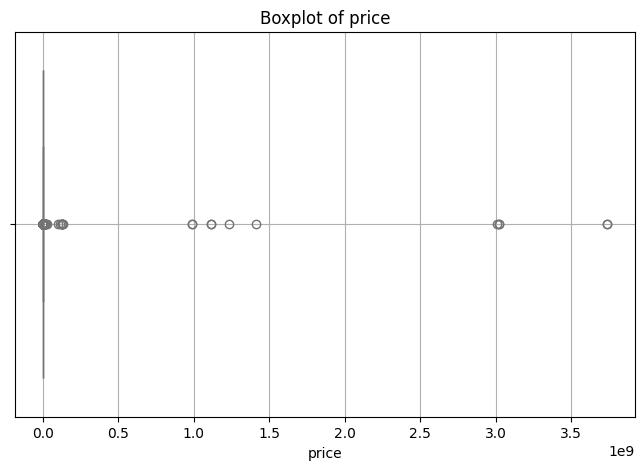

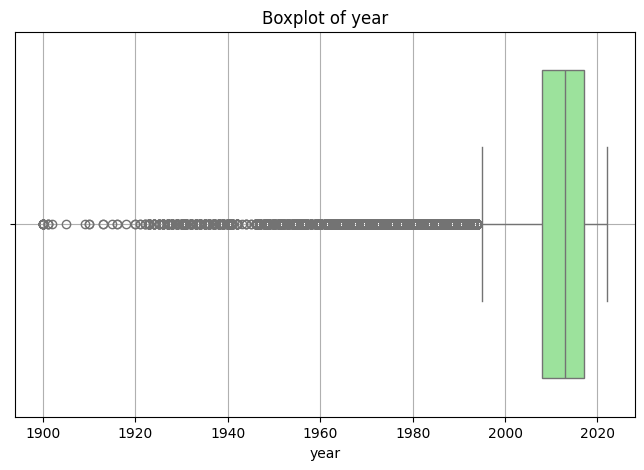

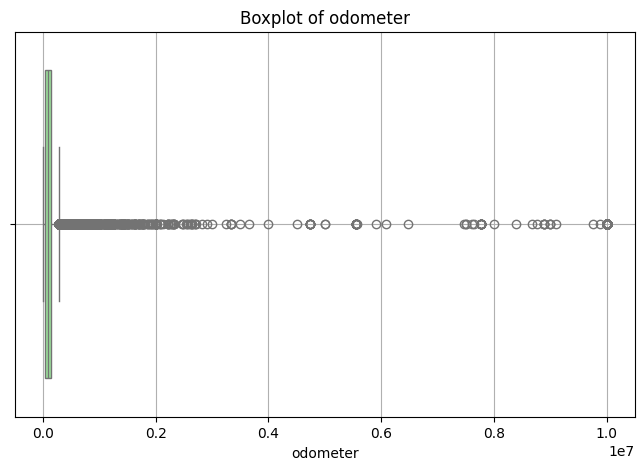

In [34]:
numerical_columns = ['price', 'year', 'odometer']

# Creamos boxplots
for col in numerical_columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=num_df, x=col, color='lightgreen')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.grid(True)
    plt.show()

No eliminamos los outliers, ya que los precios de los autotos pueden estar determinados por el estado, la marca y el kilometraje. Asi tambien, el kilometraje puede estar afectado por la la antiguedad, pero tambien del tipo de uso que se le dio al auto. Los ouliers de año tampoco pueden ser descartados. 

             price      year  odometer       lat      long
price     1.000000 -0.004931  0.010057  0.000349 -0.000430
year     -0.004931  1.000000 -0.156263 -0.014737 -0.000672
odometer  0.010057 -0.156263  1.000000 -0.001522  0.009375
lat       0.000349 -0.014737 -0.001522  1.000000 -0.126014
long     -0.000430 -0.000672  0.009375 -0.126014  1.000000


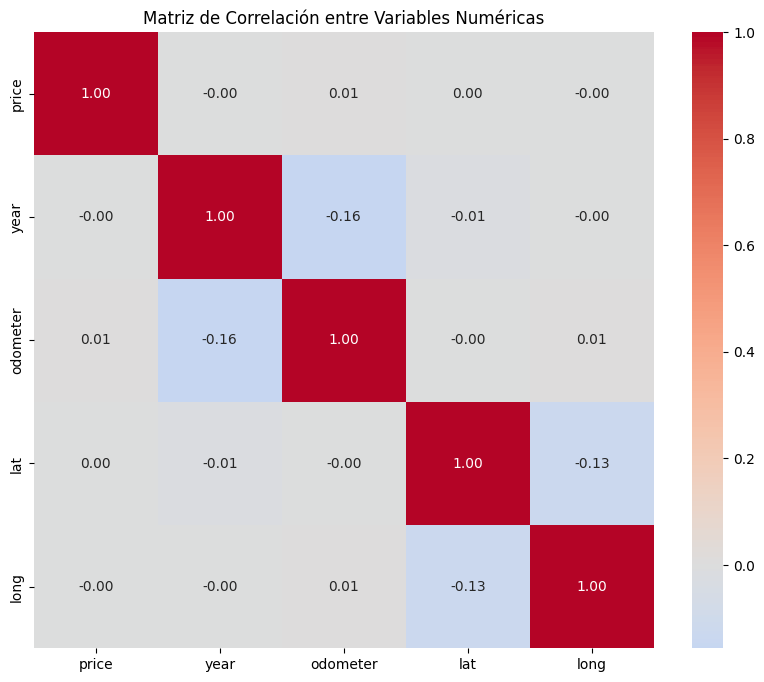

In [19]:
# Matriz de correlación
correlation_matrix = num_df.corr()
print(correlation_matrix)

# Mapa de calor de la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Matriz de Correlación entre Variables Numéricas')
plt.show()

* Calcular estadísticas descriptivas.

In [21]:
# Estadísticos descriptivos
num_df.describe()

,price,year,odometer,lat,long
count,4.148630e+05,414863.000000,4.148630e+05,414863.000000,414863.000000
mean,7.699303e+04,2011.184246,9.852984e+04,38.506160,-94.663653
std,1.235746e+07,9.509732,2.150849e+05,5.841192,18.355538
min,0.000000e+00,1900.000000,0.000000e+00,-84.122245,-159.827728
25%,5.995000e+03,2008.000000,3.791900e+04,34.620000,-111.925724
50%,1.399100e+04,2013.000000,8.600000e+04,39.171991,-88.281600
75%,2.659000e+04,2017.000000,1.341400e+05,42.418038,-80.830000
max,3.736929e+09,2022.000000,1.000000e+07,82.390818,173.885502


## **4. Modelado y Evaluación:**

* Implementar al menos dos modelos de regresión (Linear Regression y Random Forest Regressor).

* Evaluar los modelos utilizando MSE, RMSE, y R^2.

* Seleccionar el mejor modelo basado en las métricas de evaluación.

**Linear Regression**

In [22]:
# Tomamos el prcio como target
X = df_encoded.drop('price', axis=1)
y = df_encoded['price']

# Dividimos el conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamos el modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Realizamos predicciones
y_pred = model.predict(X_test)

# Evaluamos el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.2f}")


Mean Squared Error: 149038663563932.16
R-squared Score: -0.00


**Random Forest Regressor**

In [ ]:
# Entrenamos el modelo
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Realizamos predicciones
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Evaluamos el modelo
print(f"Random Forest Mean Squared Error: {mse_rf:.2f}")
print(f"Random Forest R-squared Score: {r2_rf:.2f}")

Random Forest Mean Squared Error: 139302145727909.84
Random Forest R-squared Score: 0.06


## **5. Optimización del Modelo:**

* Optimizar el modelo seleccionado utilizando GridSearchCV.

In [24]:
# Standardize your training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Define the hyperparameter grid (removing the deprecated 'normalize' parameter)
param_grid = {
    'fit_intercept': [True, False],
}

# Create a GridSearchCV object with linear regression model
grid_search = GridSearchCV(estimator=LinearRegression(), param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the training data
grid_search.fit(X_train_scaled, y_train)

# Access the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions using the best model
y_pred = best_model.predict(X_test)

# Evaluate the model using the best parameters
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (Best Model): {mse:.2f}")
print(f"R-squared Score (Best Model): {r2:.2f}")

# Print the best parameters found by GridSearchCV
print(f"Best Parameters: {best_params}")

Mean Squared Error (Best Model): 2280208834384932372480.00
R-squared Score (Best Model): -15308277.05
Best Parameters: {'fit_intercept': True}


c:\Users\damav\Desktop\Codingdojo\clases\MITIC-DataScience_MachineLearning-DanielaRiveros-2024\clases\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [1]:
# Definimos los parametros, reducimos el consumo por limitaciones de mi maquina
# Esta seccion esta comentada debido a las limitaciones de mi maquina que no la puede procesar. 

#param_grid = {
    #'n_estimators': [50, 100], 
    #'max_depth': [10, 20],             
    #'min_samples_split': [2, 5],       
#}

# Reduce cross-validation folds to 3

#grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                                #scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)

# Fit the lighter GridSearchCV

#grid_search.fit(X_train, y_train)

# Evaluate the best model
#best_rf = grid_search.best_estimator_
#y_pred_rf = best_rf.predict(X_test)

#mse_rf = mean_squared_error(y_test, y_pred_rf)
#r2_rf = r2_score(y_test, y_pred_rf)

#print(f"Random Forest Mean Squared Error: {mse_rf:.2f}")
#print(f"Random Forest R-squared Score: {r2_rf:.2f}")